# ELECTRA - Sarcasm and Sentiment Analysis in Turkish Political Discussions

This notebook is part of a larger project that aims to analyze the evolution of public discourse on Turkish politics, with a particular focus on the sarcasm analysis directed toward key political figures such as Recep Tayyip Erdoğan and Kemal Kılıçdaroğlu. By leveraging textual data from Ekşi Sözlük, this notebook outlines the steps for preprocessing the data and implementing a sarcasm detection model based on BERT architecture. The goal is to fine-tune the model to accurately identify sarcastic remarks, which are critical for a nuanced understanding of public sentiment. This work contributes to the broader aim of correlating sentiment trends with major political events and understanding the socio-political factors that shape public criticism and support for political leaders. The outcomes of this notebook will serve as a foundation for sentiment-aware models that enhance computational social science research in the context of Turkish politics.


In [ ]:
df_sarcasm_test = pd.read_excel(r"/content/erdem_tagged.xlsx", sheet_name ="All")

# predict on test set
test_texts = df_sarcasm_test['entry_text'].values

# 1. Initialize the tokenizer
tokenizer = ElectraTokenizer.from_pretrained("dbmdz/electra-base-turkish-mc4-uncased-discriminator")

# 2. Tokenize the data
test_encodings = tokenizer(list(test_texts), truncation=True, padding=True, max_length=512)

# 3. Create a Dataset object for the test set
test_dataset = SarcasmDataset(test_encodings, labels=np.zeros(len(test_texts)))

# 4. Load the trained model
model = ElectraForSequenceClassification.from_pretrained(r"/content/electra-turkish-sarcasm-checkpoints/checkpoint-2268")

# 5. Create a Trainer
trainer = Trainer(model)

# 6. Predict on the test set
predictions = trainer.predict(test_dataset)

# 7. Extract the predicted labels
predicted_labels = np.argmax(predictions.predictions, axis=-1)

# 8. Save the predictions to a CSV file
df_sarcasm_test['predicted_label'] = predicted_labels
df_sarcasm_test.to_excel('df_sarcasm_test_with_predictions.xlsx', index=False)

print("Predictions saved to 'df_sarcasm_test_with_predictions.csv'")


Predictions saved to 'df_sarcasm_test_with_predictions.csv'


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at dbmdz/electra-base-turkish-mc4-uncased-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Class weights 0/1 = [0.75753012 1.47076023]


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.694600,0.692645,0.662028,0.663586,0.662028,0.532991
2,0.625600,0.733779,0.679920,0.736820,0.679920,0.574707
3,0.611300,0.774025,0.683897,0.762453,0.683897,0.579991
4,0.583000,0.807098,0.695825,0.750812,0.695825,0.608742
5,0.539100,0.889250,0.695825,0.733638,0.695825,0.613486
6,0.532100,0.899718,0.695825,0.733638,0.695825,0.613486
7,0.540400,0.976950,0.697813,0.753460,0.697813,0.612498
8,0.466000,0.923303,0.713718,0.727254,0.713718,0.658253
9,0.384100,1.022830,0.697813,0.714763,0.697813,0.625846
10,0.430100,1.149361,0.695825,0.750812,0.695825,0.608742



Best checkpoint: 2electra-turkish-sarcasm-checkpoints/checkpoint-2016


Eşik -1.43  |  Recall=0.85  Precision=0.53


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Tahminler 'df_sarcasm_test_with_predictions.xlsx' dosyasına kaydedildi.

Classification Report:
               precision    recall  f1-score   support

           0      0.927     0.667     0.776      1665
           1      0.583     0.899     0.708       864

    accuracy                          0.746      2529
   macro avg      0.755     0.783     0.742      2529
weighted avg      0.810     0.746     0.752      2529



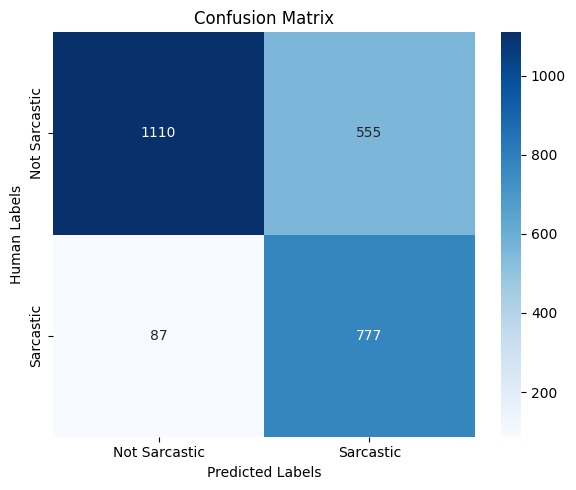

In [ ]:
# -------------------------------------------------
# 0) KURULUMLAR ve HEDEF AYARI
# -------------------------------------------------
import torch, pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    precision_recall_fscore_support,
    precision_recall_curve,
    classification_report,
    confusion_matrix,
)
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import Dataset
from transformers import (
    ElectraTokenizer,
    ElectraConfig,
    ElectraForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback,
)

TARGET_RECALL = 0.85          # ↙  İstediğiniz minimum recall (Class-1) değerini buradan ayarlayın

# -------------------------------------------------
# 1) DATASET
# -------------------------------------------------
class SarcasmDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings, self.labels = encodings, labels
    def __len__(self): return len(self.labels)
    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

# -------------------------------------------------
# 2) WEIGHTED TRAINER
# -------------------------------------------------
class WeightedTrainer(Trainer):
    def __init__(self, class_weights=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = (
            torch.tensor(class_weights, dtype=torch.float)
            if class_weights is not None else None
        )

    def compute_loss(
        self, model, inputs, return_outputs=False, num_items_in_batch=None
    ):
        labels  = inputs.get("labels")
        outputs = model(**inputs)
        logits  = outputs.get("logits")

        loss_fct = torch.nn.CrossEntropyLoss(
            weight=self.class_weights.to(logits.device) if self.class_weights is not None else None
        )
        loss = loss_fct(
            logits.view(-1, self.model.config.num_labels),
            labels.view(-1)
        )
        return (loss, outputs) if return_outputs else loss

# -------------------------------------------------
# 3) METRİK
# -------------------------------------------------
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc  = (preds == labels).mean()
    prec, rec, f1, _ = precision_recall_fscore_support(labels, preds, average="weighted")
    return {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1}

# -------------------------------------------------
# 4) EĞİTİM
# -------------------------------------------------
def train_model():
    df = pd.read_excel("/content/erdem_tagged.xlsx", sheet_name="Sarcasm")
    df["label"] = df["label"].astype(int)

    train_texts, val_texts, train_labels, val_labels = train_test_split(
        df["entry_text"].values, df["label"].values,
        test_size=0.20, random_state=42, stratify=df["label"].values
    )

    base_ckpt = "dbmdz/electra-base-turkish-mc4-uncased-discriminator"
    tokenizer = ElectraTokenizer.from_pretrained(base_ckpt)

    train_enc = tokenizer(list(train_texts), truncation=True, padding=True, max_length=512)
    val_enc   = tokenizer(list(val_texts),   truncation=True, padding=True, max_length=512)
    train_ds, val_ds = SarcasmDataset(train_enc, train_labels), SarcasmDataset(val_enc, val_labels)

    config = ElectraConfig.from_pretrained(
        base_ckpt,
        num_labels=2,
        hidden_dropout_prob=0.3,
        attention_probs_dropout_prob=0.3,
        classifier_dropout=0.3,
    )
    model = ElectraForSequenceClassification.from_pretrained(base_ckpt, config=config)

    # ilk 4 encoder katmanını dondur
    for name, param in model.named_parameters():
        if "electra.encoder.layer." in name and int(name.split(".")[3]) < 4:
            param.requires_grad = False

    class_weights = compute_class_weight("balanced", classes=np.unique(train_labels), y=train_labels)
    print(f"Class weights 0/1 = {class_weights}")

    training_args = TrainingArguments(
        output_dir="2electra-turkish-sarcasm-checkpoints",
        num_train_epochs=15,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=16,
        eval_strategy="epoch",
        save_strategy="epoch",
        logging_dir="logs",
        logging_steps=20,
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        greater_is_better=True,
        learning_rate=2e-5,
        weight_decay=0.01,
        fp16=True,
    )

    trainer = WeightedTrainer(
        model=model,
        args=training_args,
        train_dataset=train_ds,
        eval_dataset=val_ds,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
        class_weights=class_weights,
    )

    trainer.train()
    print("\nBest checkpoint:", trainer.state.best_model_checkpoint)

    # ---------- EŞİK SEÇİMİ (Recall odaklı) ----------
    val_probs = trainer.predict(val_ds).predictions[:, 1]   # sınıf-1 olasılığı
    prec, rec, thr = precision_recall_curve(val_labels, val_probs)

    # recall ≥ TARGET_RECALL koşulunu sağlayan en yüksek eşiği seç
    idxs = np.where(rec >= TARGET_RECALL)[0]
    if len(idxs):
        idx = idxs[-1]
        best_thr = thr[idx] if idx < len(thr) else 0.0
    else:
        best_thr = 0.0   # hedef sağlanamıyorsa en düşük eşiğe in
    print(f"Eşik {best_thr:.2f}  |  Recall={rec[idx]:.2f}  Precision={prec[idx]:.2f}")

    return trainer, tokenizer, best_thr

# -------------------------------------------------
# 5) TEST TAHMİN
# -------------------------------------------------
def predict_test(trainer, tokenizer, threshold):
    df_test = pd.read_excel("/content/erdem_tagged.xlsx", sheet_name="All")
    test_texts = df_test["entry_text"].values

    test_enc = tokenizer(list(test_texts), truncation=True, padding=True, max_length=512)
    test_ds  = SarcasmDataset(test_enc, labels=np.zeros(len(test_texts)))

    logits = trainer.predict(test_ds).predictions[:, 1]
    preds  = (logits >= threshold).astype(int)

    df_test["predicted_label"] = preds
    out_path = Path("df_sarcasm_test_with_predictions.xlsx")
    df_test.to_excel(out_path, index=False)
    print(f"Tahminler '{out_path}' dosyasına kaydedildi.")
    return df_test

# -------------------------------------------------
# 6) DEĞERLENDİRME
# -------------------------------------------------
def evaluate_against_gold(pred_df):
    gold_df = pd.read_excel("/content/erdem_tagged.xlsx", sheet_name="Sarcasm")
    merged  = pd.merge(gold_df, pred_df[["entry_text", "predicted_label"]], on="entry_text")
    y_true, y_pred = merged["label"], merged["predicted_label"]

    print("\nClassification Report:\n", classification_report(y_true, y_pred, digits=3))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Not Sarcastic", "Sarcastic"],
                yticklabels=["Not Sarcastic", "Sarcastic"])
    plt.title("Confusion Matrix")
    plt.ylabel("Human Labels")
    plt.xlabel("Predicted Labels")
    plt.tight_layout()
    plt.show()

# -------------------------------------------------
# 7) MAIN
# -------------------------------------------------
if __name__ == "__main__":
    trainer, tokenizer, best_threshold = train_model()
    pred_df = predict_test(trainer, tokenizer, best_threshold)
    evaluate_against_gold(pred_df)


In [ ]:
df_sarcasm_test = pd.read_excel(r"/content/filtered_ekşi_sozluk_traditional_ml.xlsx")

# predict on test set
test_texts = df_sarcasm_test['processed_text'].values

df_sarcasm_test['processed_text'] = df_sarcasm_test['processed_text'].fillna("")
test_texts = df_sarcasm_test['processed_text'].astype(str).values

# 1. Initialize the tokenizer
tokenizer = ElectraTokenizer.from_pretrained('dbmdz/electra-base-turkish-mc4-uncased-discriminator')

# 2. Tokenize the data
test_encodings = tokenizer(list(test_texts), truncation=True, padding=True, max_length=512)

# 3. Create a Dataset object for the test set
test_dataset = SarcasmDataset(test_encodings, labels=np.zeros(len(test_texts)))

# 4. Load the trained model
model = ElectraForSequenceClassification.from_pretrained(r"/content/2electra-turkish-sarcasm-checkpoints/checkpoint-2016")

# 5. Create a Trainer
trainer = Trainer(model)

# 6. Predict on the test set
predictions = trainer.predict(test_dataset)

# 7. Extract the predicted labels
predicted_labels = np.argmax(predictions.predictions, axis=-1)

# 8. Save the predictions to a CSV file
df_sarcasm_test['New_predicted_label'] = predicted_labels
df_sarcasm_test.to_excel('all_df_sarcasm_test_with_predictions.xlsx', index=False)

print("Predictions saved")


Predictions saved


In [ ]:
# Load the Excel file
filtered_df = pd.read_excel(r"/content/all_df_sarcasm_test_with_predictions.xlsx")

# Convert entry_date to period (monthly)
filtered_df['entry_date'] = pd.to_datetime(filtered_df['entry_date']).dt.to_period('M')

# Group by new_predicted_label, topic, and entry_date, and count the entries
grouped_df = filtered_df.groupby(['New_predicted_label', 'topic', 'entry_date']).size().reset_index(name='count')

# Filter the grouped data where New_predicted_label is 1
filtered_grouped_df = grouped_df[grouped_df['New_predicted_label'] == 1]

# Sort entry_date to avoid x-axis issues
filtered_grouped_df = filtered_grouped_df.sort_values(by='entry_date')

# Get unique topics for plotting
unique_filtered_topics = filtered_grouped_df['topic'].unique()

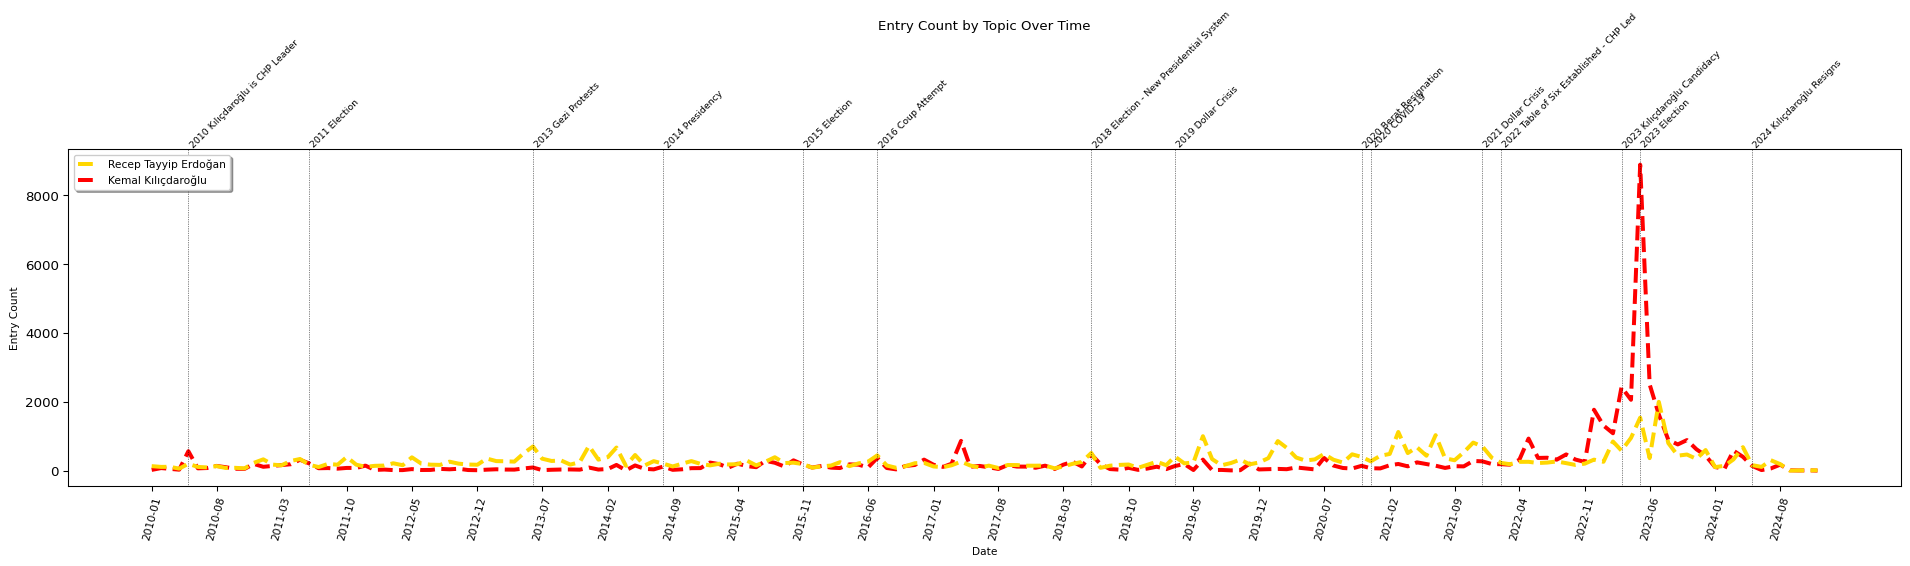

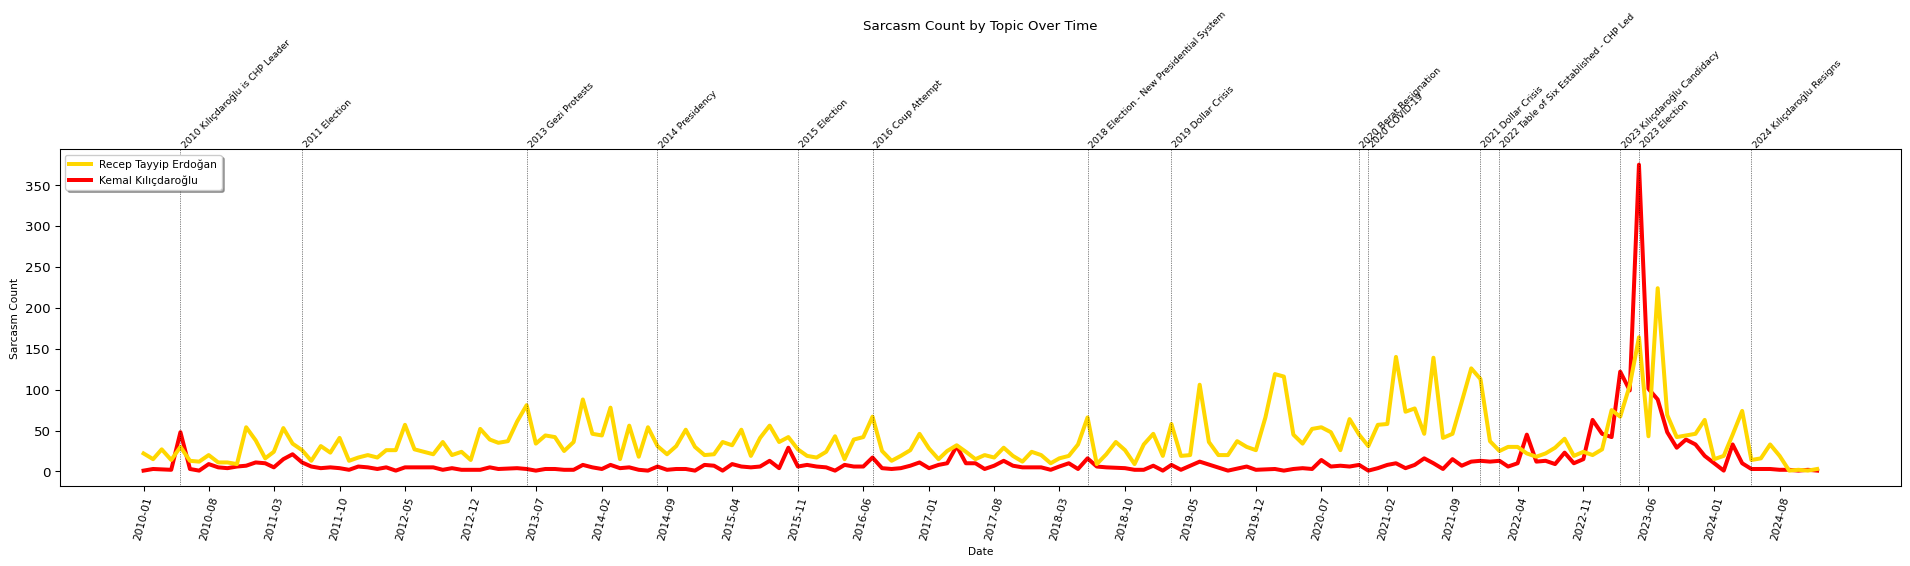

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the Excel file
df = pd.read_excel(r"/content/all_df_sarcasm_test_with_predictions.xlsx")

start_date = 2010
end_date = 2025

significant_dates = {
    '2008-09': '2008 Global Crisis',      # Küresel ekonomik kriz
    '2008-11': '2008 Mortgage Crisis',    # Mortgage krizi sonrası dalgalanma
    '2010-05': '2010 Kılıçdaroğlu is CHP Leader',  # Kemal Kılıçdaroğlu became leader of the Republican People's Party (CHP)
    '2011-06': '2011 Election',           # AK Parti'nin %50 oy aldığı seçim
    '2013-06': '2013 Gezi Protests',      # Gezi Parkı olayları
    '2014-08': '2014 Presidency',         # İlk doğrudan cumhurbaşkanlığı seçimi
    '2015-11': '2015 Election',           # Kasım seçimleri, siyasi kriz sonrası
    '2016-07': '2016 Coup Attempt',       # 15 Temmuz darbe girişimi
    '2018-06': '2018 Election - New Presidential System',  # Cumhurbaşkanlığı Hükümet Sistemi'nin ilk seçimi
    '2019-03': '2019 Dollar Crisis',      # Dolar/TL dalgalanmaları ve ekonomik sıkıntılar
    '2020-11': '2020 Berat Resignation',  # Berat Albayrak'ın istifası
    '2020-12': '2020 COVID-19',           # COVID-19 pandemisi
    '2021-12': '2021 Dollar Crisis',      # Kur şoku ve dolar/TL rekor seviyeleri
    '2022-02': '2022 Table of Six Established - CHP Led', # 6'lı masa kuruldu
    '2023-03': '2023 Kılıçdaroğlu Candidacy', # Kılıçdaroğlu adaylığı açıklandı
    '2023-05': '2023 Election',           # Cumhurbaşkanlığı ve parlamento seçimleri
    '2024-05': '2024 Kılıçdaroğlu Resigns'     # Expected or possible resignation after the 2023 elections
}

# Filter significant dates to include only those within the range of the dataframe
significant_dates = {date: event for date, event in significant_dates.items() if start_date <= pd.to_datetime(date).year <= end_date}

# Filter data to get only entries with year > 2005
df = df[(pd.to_datetime(df['entry_date']).dt.year >= start_date) & (pd.to_datetime(df['entry_date']).dt.year <= end_date)]


# Convert entry_date to period (monthly) and sort by entry_date
df['entry_date'] = pd.to_datetime(df['entry_date']).dt.to_period('M')
df = df.sort_values(by='entry_date')

# Group by entry_date and topic, and count the number of entries
grouped_df = df.groupby(['entry_date', 'topic']).size().reset_index(name='count')

# Ensure entry_date is ordered and converted to datetime for plotting
grouped_df['entry_date'] = grouped_df['entry_date'].dt.to_timestamp()

# Define the color map
color_map = {
    'recep tayyip erdoğan': '#FFD700',  # Koyu sarı
    'kemal kılıçdaroğlu': 'red'         # Kırmızı
}

# Create a figure for entry count
plt.figure(figsize=(20, 6), dpi=96)  # 10 inches by 5 inches, 96 DPI

# Plot entry count
for topic in grouped_df['topic'].unique():
    topic_df = grouped_df[grouped_df['topic'] == topic]
    plt.plot(topic_df['entry_date'], topic_df['count'], linestyle='--', color=color_map.get(topic, 'blue'), label=topic, linewidth=3)

plt.xlabel('Date', fontsize=8)
plt.ylabel('Entry Count', fontsize=8)
plt.title('Entry Count by Topic Over Time', fontsize=10,pad=90)

# Limit the number of x-axis labels (tick reduction)
x_dates = grouped_df['entry_date'].unique()
num_ticks = 25
plt.xticks(ticks=x_dates[::max(1, len(x_dates) // num_ticks)], labels=[date.strftime('%Y-%m') for date in x_dates[::max(1, len(x_dates) // num_ticks)]], rotation=75, fontsize=8)

# Add significant dates to the plot
for significant_date, event in significant_dates.items():
    date = pd.to_datetime(significant_date)
    plt.axvline(x=date, color='k', linestyle=':', linewidth=0.5)
    plt.text(date, plt.ylim()[1], event, rotation=45, verticalalignment='bottom', fontsize=7)

# Custom legend order
handles, labels = plt.gca().get_legend_handles_labels()
order = [labels.index(label) for label in ['recep tayyip erdoğan', 'kemal kılıçdaroğlu'] if label in labels]
plt.legend([handles[idx] for idx in order], ['Recep Tayyip Erdoğan', 'Kemal Kılıçdaroğlu'], loc='upper left', frameon=True, shadow=True, fontsize=8)

# Save the figure
plt.tight_layout()
plt.savefig('entry_count_plot.png', dpi=300)
plt.show()

# Create sarcasm count data (assuming sarcasm predictions are stored in a column named 'New_predicted_label')
grouped_label_df = df[df['New_predicted_label'] == 1].groupby(['entry_date', 'topic']).size().reset_index(name='count')
grouped_label_df['entry_date'] = grouped_label_df['entry_date'].dt.to_timestamp()

# Create a figure for sarcasm count
plt.figure(figsize=(20, 6), dpi=96)  # 10 inches by 5 inches, 96 DPI

# Plot sarcasm count
for topic in grouped_label_df['topic'].unique():
    topic_df = grouped_label_df[grouped_label_df['topic'] == topic]
    plt.plot(topic_df['entry_date'], topic_df['count'], linestyle='-', color=color_map.get(topic, 'blue'), label=topic, linewidth=3)

plt.xlabel('Date', fontsize=8)
plt.ylabel('Sarcasm Count', fontsize=8)
plt.title('Sarcasm Count by Topic Over Time', fontsize=10,pad=90)

plt.xticks(ticks=x_dates[::max(1, len(x_dates) // num_ticks)], labels=[date.strftime('%Y-%m') for date in x_dates[::max(1, len(x_dates) // num_ticks)]], rotation=75, fontsize=8)

# Add significant dates to the plot
for significant_date, event in significant_dates.items():
    date = pd.to_datetime(significant_date)
    plt.axvline(x=date, color='k', linestyle=':', linewidth=0.5)
    plt.text(date, plt.ylim()[1], event, rotation=45, verticalalignment='bottom', fontsize=7)

# Custom legend order
handles, labels = plt.gca().get_legend_handles_labels()
order = [labels.index(label) for label in ['recep tayyip erdoğan', 'kemal kılıçdaroğlu'] if label in labels]
plt.legend([handles[idx] for idx in order], ['Recep Tayyip Erdoğan', 'Kemal Kılıçdaroğlu'], loc='upper left', frameon=True, shadow=True, fontsize=8)

# Save the figure
plt.tight_layout()
plt.savefig('sarcasm_count_plot.png', dpi=300)
plt.show()



Summary Statistics by Topic:
                      Total Entries  Sarcastic Entries  Sarcasm Percentage
topic                                                                     
kemal kılıçdaroğlu            49274               2196                4.46
recep tayyip erdoğan          54939               6927               12.61

Total number of entries: 104213
Total number of sarcastic entries: 9123
Overall sarcasm percentage: 8.75%


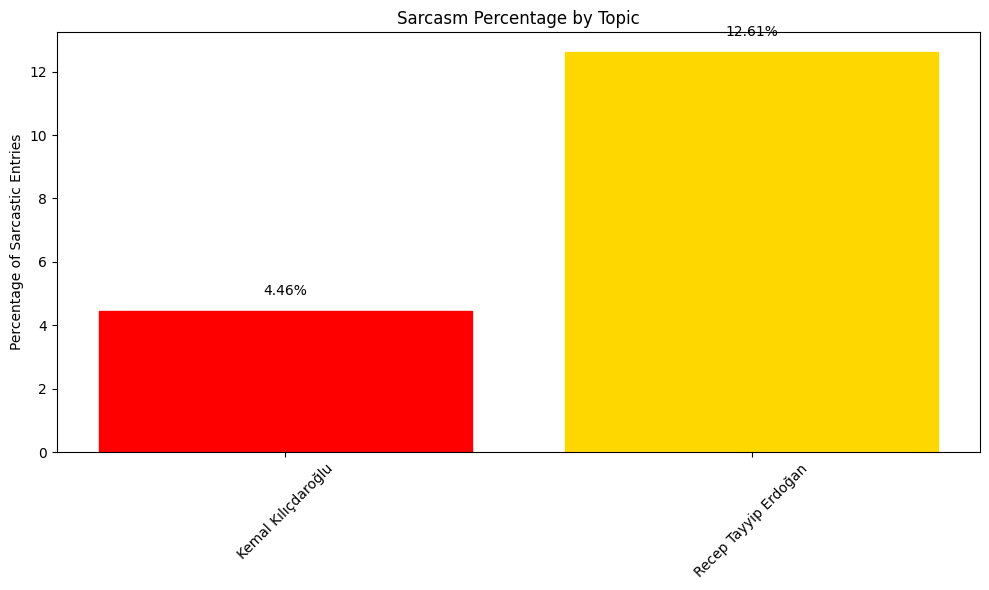

In [ ]:

# Group by topic to get total entries
topic_totals = df.groupby('topic').size()

# Group by topic and count sarcastic entries (New_predicted_label == 1)
sarcasm_totals = df[df['New_predicted_label'] == 1].groupby('topic').size()

# Calculate percentage of sarcastic entries per topic
sarcasm_percentages = (sarcasm_totals / topic_totals * 100).round(2)

# Create summary table
summary_df = pd.DataFrame({
    'Total Entries': topic_totals,
    'Sarcastic Entries': sarcasm_totals,
    'Sarcasm Percentage': sarcasm_percentages
})

print("\nSummary Statistics by Topic:")
print(summary_df)

print("\nTotal number of entries:", len(df))
print("Total number of sarcastic entries:", df['New_predicted_label'].sum())
print("Overall sarcasm percentage: {:.2f}%".format(df['New_predicted_label'].mean() * 100))
# Create a bar plot
plt.figure(figsize=(10, 6))

# Plot bars for each topic
bars = plt.bar(summary_df.index, summary_df['Sarcasm Percentage'])

# Customize bar colors
for i, bar in enumerate(bars):
    if summary_df.index[i] == 'recep tayyip erdoğan':
        bar.set_color('#FFD700')  # Gold
    else:
        bar.set_color('red')

# Add value labels on top of bars
for i, v in enumerate(summary_df['Sarcasm Percentage']):
    plt.text(i, v + 0.5, f'{v:.2f}%', ha='center')

# Customize the plot
plt.title('Sarcasm Percentage by Topic')
plt.ylabel('Percentage of Sarcastic Entries')
plt.xticks(range(len(summary_df.index)), [name.title() for name in summary_df.index], rotation=45)

# Adjust layout and display
plt.tight_layout()
plt.show()